<a href="https://colab.research.google.com/github/khalil-alexander/get_forecast/blob/main/FuturePositionISS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color="red"> Pip install Astropy in google colab <font/>
### <font color="Green"> We install astropy in order to convert kilometre to longitatide later <font/>

In [ ]:
!pip install astropy

## <font color="red"> Install Moudles in google colab <font/>

In [ ]:
from astropy import coordinates as coord
from astropy import units as u
from astropy import time
from astropy.time import Time
from astropy.coordinates import Angle

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import requests as reqs
import xml.etree.ElementTree as ET
import io
import pprint
import json
import datetime

In [ ]:
from datetime import datetime
import datetime as dt
from datetime import timezone

In [ ]:
import xarray as xr

# <font color="red">Why is the International Space Station (ISS) important?<font/>

### <font color="blue">The ISS hosts research for new space technologies, microbiology, studying diseases, and physics through microgravity. The ISS is the largest statilte that orbits the earth.<font/>


# <font color="red">What is a orbit?<font/>

### <font color="blue">An orbit is when the ISS crosses the antimeridian<font/>


# <font color="red">What do we need to know?<font/>
- ## <font color="blue">Astropy <font/>
- ## <font color="blue"> Datetime <font/>
- ## <font color="blue">Pandas <font/>
- ## <font color="blue">Xarray <font/>


## <font color="red">What is Astropy? <font/>
### <font color="blue">Astropy is a Python package designed specifically for astronomy. There are tools that handle units which will be useful for us later. <font/>


## <font color="red">What is Datetime?
### <font color="blue">Datetime is a Python module that provides classes for dates and time. We use datetime to get real time data for the ISS position<font/>

## <font color="red">What is Pandas?
### <font color="blue">An open source python libary used for data manipulation and analysis <font/>

## <font color="red">What is Xarray?
### <font color="blue">An open source project and Python package that works with multi-dimensional data<font/>

## <font color="red"> Converting coordinates to Latitude and Longitude ISS</font>
### <font color="blue"> Using astropy we were able to convery kilometre to longitude and latitude. <font/>

In [ ]:
now = Time("2024-03-07 00:46:00.000", scale='utc')
xyz = [1155.746046202530, -6632.420367726780, 953.533229633281]
cartrep = coord.CartesianRepresentation(*xyz, unit=u.km)



gcrs = coord.GCRS(cartrep, obstime = now)
itrs = gcrs.transform_to(coord.ITRS(obstime = now))
loc = coord.EarthLocation(*itrs.cartesian.xyz)

print(loc.lat, loc.lon, loc.height)

8d07m57.90103915s 103d26m20.85144985s 421.8445702007271 km


## <font color="red"> Creating functions to clean up Latitude and Longitude ISS <font/>

### <font color="green">Create an empty dateframe for functions <font/>

### <font color="blue">Create two function that changes km to lat/lon <font/>


<font color="Burgundy"> First an empty pandas dataframe with only 7 column names were created. The pandas dataframe will help store the data in a two-dimentional data structure. This will help to store the data from web scraping later.<font/>


In [ ]:
col_name = ['Date','x units(km)','y units(km)','z units(km)','x_dot(km/s)','y_dot(km/s)','z_dot(km/s)']
# Challenge to have the columns read under beautiful soup
xml_df = pd.DataFrame(columns=col_name)
xml_df

,Date,x units(km),y units(km),z units(km),x_dot(km/s),y_dot(km/s),z_dot(km/s)


<font color="Burgundy"> We create a functions to convert the x units and y units to latitude and longitude that we will have in our Pandas dataframe that we previously created through astropy.<font/>

In [ ]:
def create_latlon_positions(date: str, xyz: list[float]):
    now = Time(date, scale='utc')
    cartrep = coord.CartesianRepresentation(*xyz, unit=u.km)

    gcrs = coord.GCRS(cartrep, obstime = now)
    itrs = gcrs.transform_to(coord.ITRS(obstime = now))
    loc = coord.EarthLocation(*itrs.cartesian.xyz)

    return Angle(loc.lat).deg, Angle(loc.lon).deg


In [ ]:
def get_latlon(row: pd.Series):
    date = row['Date'].strftime('%Y-%m-%d %H:%M:%S')
    xyz = [row['x units(km)'], row['y units(km)'], row['z units(km)']]
    return create_latlon_positions(date, xyz)




## <font color="red"> read_xml_DateFrame <font/>
### <font color="green">A function that reads an xml file and returns the specfic position the iss is at during different time. <font/>

<font color="blue"> We pass in the url of an XML file:https://nasa-public-data.s3.amazonaws.com/iss-coords/current/ISS_OEM/ISS.OEM_J2K_EPH.xml
<font color="blue"> We use the XML file to webscrap data on the the position of the ISS and time the ISS was in that posistion.

<font color="blue"> In order to clean up the data we use Beautifulsoup

### <font color="green">What is Beautifulsoup? <font/>

<font color="blue">Beautifulsoup is a python libary that is used to pull XML and HTML files. In this case we want to pull out an XML file. <font/>

<font color="blue">The XML file we used to extract data from: https://nasa-public-data.s3.amazonaws.com/iss-coords/current/ISS_OEM/ISS.OEM_J2K_EPH.xml <font/>

In [ ]:
def read_xml_DataFrame(url):
    """
    Do web scraping from an XML file to obtain time the International Space
    Station will be at a specfic postion and the speed it is going at.

    Parameters
    ----------
    url : String
        The url of the data in XML format you want to extract from.

    Return
    ------
    df : Pandas DataFrame
        The DataFrame containing the time the International Space Station is at
        a specfic position and the speed it is traveling.
    """
    # Get the xml request
    xml = reqs.get(url)

    # Use BeautifulSoup to Organize the XML file
    soup = BeautifulSoup(xml.content,"lxml")

    # Finds all the instances 'statevector' appeared in the xml file
    state_tag = soup.find_all('statevector')

    col_name = ['Date','x units(km)',
                'y units(km)','z units(km)',
                'x_dot(km/s)',
                'y_dot(km/s)','z_dot(km/s)']
    df = pd.DataFrame(columns=col_name)

    #Loops thorugh all elements to add rows in the empty xml_df
    for element in state_tag:
        # Turns element into text and splits the '\n'
        element = element.text.split('\n')
        # Deletes First empty String
        element.pop(0)
        # Deletes Last empty Sting
        element.pop(-1)
        # Removes the 'Z' in the elements first index
        element[0] = element[0][:-1]

        # Appending list into DataFrame by adding 1 row to the DataFrame
        #df = xml_df.append(pd.DataFrame(element, columns=col_name), ignore_index=True)
        df.loc[len(df)] = element


    # Turns the "Date" collumn into a Datetime object
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%jT%H:%M:%S.%f')
    # Sets the "Date" collumn into a Datetime object
    #df.set_index("Date", inplace=True)

    # Returns the Dataframe
    return df

In [ ]:
xml_url = "https://nasa-public-data.s3.amazonaws.com/iss-coords/current/ISS_OEM/ISS.OEM_J2K_EPH.xml"
%time df = read_xml_DataFrame(xml_url)

<ipython-input-10-ea97148a76b9>:21: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  soup = BeautifulSoup(xml.content,"lxml")


CPU times: user 9.88 s, sys: 179 ms, total: 10.1 s
Wall time: 12.8 s


In [ ]:
df

,Date,x units(km),y units(km),z units(km),x_dot(km/s),y_dot(km/s),z_dot(km/s)
0,2024-12-16 12:00:00,2530.0925619999998,-5793.1040169999997,2492.971861,5.5140618520000002,0.110101371,-5.3155027349999999
1,2024-12-16 12:04:00,3745.3369116765102,-5556.2554683507897,1141.85435508007,4.5511423930659598,1.8515470784880801,-5.8748339464817896
2,2024-12-16 12:08:00,4688.11538716009,-4915.2034942574601,-292.56941473892698,3.2574803461366799,3.4578039552412698,-6.0054971215620103
3,2024-12-16 12:12:00,5290.0057729980399,-3916.74640148853,-1705.6735298408901,1.7278649636293499,4.8117280158647899,-5.6983546344379299
4,2024-12-16 12:16:00,5507.5371963421403,-2633.6953227078802,-2994.5199626172198,0.074117098996770006,5.8150156338086996,-4.9764850544043604
...,...,...,...,...,...,...,...
5801,2024-12-31 11:45:00,4181.2240357022101,5278.8492490477302,-882.94491238617695,-3.2715734308012898,3.5739868420596799,5.9397105156128296
5802,2024-12-31 11:49:00,3253.0822296708102,5933.5702997052804,557.45769569768299,-4.4157414676358702,1.84831531442074,5.9899021432908803
5803,2024-12-31 11:53:00,2087.46978866376,6155.1277497369301,1957.03146356659,-5.23819641464108,-0.0134208890283,5.6014941379007999
5804,2024-12-31 11:57:00,769.42303002295102,5927.2031178080797,3213.2763270120799,-5.6781775285530101,-1.8742276623924401,4.8028884784601296


#### <font color="green">Adds latitude and longitude to the Data Frame <font/>

<font color="Burgundy"> We use the get_latlon function to have the dataframe return only the date, latitude, and longitude <font/>

In [ ]:
%time df[['lat','lon']] = df.apply(get_latlon, axis=1, result_type='expand')

CPU times: user 50.3 s, sys: 910 ms, total: 51.2 s
Wall time: 51 s


## <font color="red">Confrim if lat is below 50 and above -50 <font/>
### <font color="green">We do this because the International Space Station does not travel past 50 and -50 degrees latitude. <font/>

### <font color="green">verify_latitude function <font/>
- <font color="blue">Returns the min and max latitude in a tuple so the observer can see if the latitude matches the International Space Station path. <font/>

In [ ]:
def check_latitude(df: pd.DataFrame):
    """
    Gives the minimum and maximum latitude of the path the ISS travels in a
    DataFrame.

    Parameters
    ----------
    df : Pandas Dataframe
        The url of the data in XML format you want to extract from.

    Return
    ------
    df : Tuple
        Returns df max and min latitude.
    """
    return df['lat'].min(), df['lat'].max()

<font color="Burgundy"> We see that the latitude goes up to 52 degrees which could happen with error from translating y units to latitude. <font/>

In [ ]:
check_latitude(df)

(-51.79485822064892, 51.795317837821344)

In [ ]:
df = df[['Date','lat','lon']]

In [ ]:
df

,Date,lat,lon
0,2024-12-16 12:00:00,21.699944,28.239867
1,2024-12-16 12:04:00,9.807169,37.657866
2,2024-12-16 12:08:00,-2.386864,46.341775
3,2024-12-16 12:12:00,-14.504548,55.194662
4,2024-12-16 12:16:00,-26.146506,65.159742
...,...,...,...
5801,2024-12-31 11:45:00,-7.427803,135.277838
5802,2024-12-31 11:49:00,4.808260,143.947174
5803,2024-12-31 11:53:00,16.904271,152.973717
5804,2024-12-31 11:57:00,28.433946,163.343236


## <font color="red">Functions <font/>

#### <font color="blue"> The functions below are used to only extract the ISS position for 6 hours. We also make sure to obtain only the future dates, we have a parameter nhours the controls how many hours from the current time to start collecting data. If you do not pass in anything for nhours the defult value will be 3. <font/>

### 1. <font color="green">obtain_future_date <font/>
- <font color="blue">A function where you take the have argurements Pandas Dataframe and nhours.
The function takes the current time and adds in by nhours which the default is three. You will pass in a Pandas dataframe that will take the future values between startdate and 24 hours ahead. <font/>



In [ ]:
def obtain_future_date(df: pd.DataFrame, nhours: int=3):
    """
    Collects future position of the ISS with nhours from current time and 6
    hours ahead of nhours

    Parameters
    ----------
    df : Pandas Dataframe
        Dataframe which contains a column with datetime objects.

    nhours: Int
        Number of hours you want to start collecting data from current time.

    Return
    ------
    df : Pandas DataFrame
        The DataFrame containing the time the International Space Station
        from current time + nhours to 6 hours ahead.
    """
    # String of the current time of day now
    start_date = dt.datetime.now() + dt.timedelta(hours=nhours)
    #end_date = start_date + dt.timedelta(hours=24)
    # Turns the date from a string object to a datetime object
    start_date = start_date.strftime("%m/%d/%Y %H:%M:%S")
    start_date = pd.to_datetime(start_date, format='%m/%d/%Y %H:%M:%S')

    end_date = start_date + dt.timedelta(hours=6)
    #end_date = end_date.strftime("%m/%d/%Y %H:%M:%S")
    #end_date = pd.to_datetime(start_date, format='%m/%d/%Y %H:%M:%S')
    #return (start_date, end_date)

    return df[(start_date <= df['Date']) & (end_date >= df['Date'])]

<font color="Burgundy"> We aranged the index of the Dataframe <font/>

In [ ]:
df1 = obtain_future_date(df)
df1.index = range(len(df1))

In [ ]:
df1

,Date,lat,lon
0,2024-12-19 21:37:00,47.218523,120.308366
1,2024-12-19 21:41:00,51.466429,142.277749
2,2024-12-19 21:45:00,50.688026,165.990542
3,2024-12-19 21:49:00,45.153690,-173.332953
4,2024-12-19 21:53:00,36.346489,-157.428783
...,...,...,...
85,2024-12-20 03:17:00,-38.429323,-63.012432
86,2024-12-20 03:21:00,-28.050789,-50.181553
87,2024-12-20 03:25:00,-16.507556,-39.891409
88,2024-12-20 03:29:00,-4.402948,-30.894169


<font color="Burgundy"> Rename the column from 'Date' to 't', this will be useful later for time interpolation using an xarray.<font/>

In [ ]:
df1.rename(columns={'Date': 't',}, inplace=True)

<ipython-input-21-f5fb0ce3a68a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename(columns={'Date': 't',}, inplace=True)


# <font color="red"> Time interpoltation<font/>

In [ ]:
df1

,t,lat,lon
0,2024-12-19 21:37:00,47.218523,120.308366
1,2024-12-19 21:41:00,51.466429,142.277749
2,2024-12-19 21:45:00,50.688026,165.990542
3,2024-12-19 21:49:00,45.153690,-173.332953
4,2024-12-19 21:53:00,36.346489,-157.428783
...,...,...,...
85,2024-12-20 03:17:00,-38.429323,-63.012432
86,2024-12-20 03:21:00,-28.050789,-50.181553
87,2024-12-20 03:25:00,-16.507556,-39.891409
88,2024-12-20 03:29:00,-4.402948,-30.894169


## <font color="red">Functions<font/>
###1. <font color="green"> get_orbit<font/>
#### <font color="blue">A function that creates a data frame with a full orbit. We determine a full orbit by getting the second instance where longitude switches from positive to negative.<font/>

In [ ]:
def get_orbit(df: pd.DataFrame):
    count = 0
    temp_df = df['lon']

    for i in range(len(temp_df)-1):
        if (temp_df[i] > 0) and (temp_df[i+1] < 0):
            count += 1
            if count == 2:
                new_df = df.loc[low:i]
                return new_df
            low = i+1

In [ ]:
df_orbit = get_orbit(df1)

<font color="Burgundy"> Set the date as the index and change the name from 'date' to 't' for time interpoltation later. <font/>

In [ ]:
df_orbit.set_index('t', inplace=True)

In [ ]:
df_orbit

,lat,lon
t,,
2024-12-19 21:49:00,45.153690,-173.332953
2024-12-19 21:53:00,36.346489,-157.428783
2024-12-19 21:57:00,25.654706,-145.264541
2024-12-19 22:01:00,13.966888,-135.357346
2024-12-19 22:05:00,1.832212,-126.526827
2024-12-19 22:09:00,-10.351897,-117.833634
2024-12-19 22:13:00,-22.207229,-108.372938
2024-12-19 22:17:00,-33.251446,-97.062447
2024-12-19 22:21:00,-42.730809,-82.502936


## <font color="red"> Function <font/>
### <font color="green"> 1. count_orbit <font/>
#### <font color="blue"> A function that counts the amount of time in the dataframe where the longitude switched from positive to negative. This is how we determine the orbits. <font/>

In [ ]:
def count_orbit(df: pd.DataFrame):
    count = 0
    temp_df = df['lon']

    for i in range(len(temp_df)-1):
        if (temp_df[i] > 0) and (temp_df[i+1] < 0):
            count += 1
            print(i, temp_df[i], temp_df[i+1])
    return count

In [ ]:
orbit = count_orbit(df_orbit)

<ipython-input-27-ce539bacc193>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (temp_df[i] > 0) and (temp_df[i+1] < 0):


<font color="Burgundy"> Since we got a value of zero we can confrim the dataframe df_orbit is a full orbit. We can tell because the longitude starts from a value close to -180 and ends with a value clost to 180. <font/>

<font color="Burgundy"> If we got a value of 1 or more we know we got more than a full orbit. <font/>

In [ ]:
orbit

0

In [ ]:
df_orbit

,lat,lon
t,,
2024-12-19 21:49:00,45.153690,-173.332953
2024-12-19 21:53:00,36.346489,-157.428783
2024-12-19 21:57:00,25.654706,-145.264541
2024-12-19 22:01:00,13.966888,-135.357346
2024-12-19 22:05:00,1.832212,-126.526827
2024-12-19 22:09:00,-10.351897,-117.833634
2024-12-19 22:13:00,-22.207229,-108.372938
2024-12-19 22:17:00,-33.251446,-97.062447
2024-12-19 22:21:00,-42.730809,-82.502936


## <font color="red"> Getting full orbit <font/>

## <font color="green"> xarray <font/>

In [ ]:
def changeto_xarray(df):
    """
    Using a previous DataFrame and converting it into an Xarray.

    Parameters
    ----------
    df : Pandas DataFrame



    Return
    ------
    ds : Xarray
        The Xarray containing the collected following data variables:
        Date, Latitude(lat), and Longitude(lon).

    """

    #Converts the hourly  DateTime object to an Xarray object which return a more percise time with it's weather conditions
    ds = df.to_xarray()

    return ds

In [ ]:
len(df_orbit)

25

In [ ]:
test_ds = changeto_xarray(df_orbit)

In [ ]:
test_ds

<xarray.Dataset> Size: 600B
Dimensions:  (t: 25)
Coordinates:
  * t        (t) datetime64[ns] 200B 2024-12-19T21:49:00 ... 2024-12-19T23:25:00
Data variables:
    lat      (t) float64 200B 45.15 36.35 25.65 13.97 ... 51.0 51.26 46.57 38.29
    lon      (t) float64 200B -173.3 -157.4 -145.3 -135.4 ... 137.8 159.4 176.2

In [ ]:
df_orbit

,lat,lon
t,,
2024-12-19 21:49:00,45.153690,-173.332953
2024-12-19 21:53:00,36.346489,-157.428783
2024-12-19 21:57:00,25.654706,-145.264541
2024-12-19 22:01:00,13.966888,-135.357346
2024-12-19 22:05:00,1.832212,-126.526827
2024-12-19 22:09:00,-10.351897,-117.833634
2024-12-19 22:13:00,-22.207229,-108.372938
2024-12-19 22:17:00,-33.251446,-97.062447
2024-12-19 22:21:00,-42.730809,-82.502936


In [ ]:
#start_date =
df_orbit.index

DatetimeIndex(['2024-12-19 21:49:00', '2024-12-19 21:53:00',
               '2024-12-19 21:57:00', '2024-12-19 22:01:00',
               '2024-12-19 22:05:00', '2024-12-19 22:09:00',
               '2024-12-19 22:13:00', '2024-12-19 22:17:00',
               '2024-12-19 22:21:00', '2024-12-19 22:25:00',
               '2024-12-19 22:29:00', '2024-12-19 22:33:00',
               '2024-12-19 22:37:00', '2024-12-19 22:41:00',
               '2024-12-19 22:45:00', '2024-12-19 22:49:00',
               '2024-12-19 22:53:00', '2024-12-19 22:57:00',
               '2024-12-19 23:01:00', '2024-12-19 23:05:00',
               '2024-12-19 23:09:00', '2024-12-19 23:13:00',
               '2024-12-19 23:17:00', '2024-12-19 23:21:00',
               '2024-12-19 23:25:00'],
              dtype='datetime64[ns]', name='t', freq=None)

<font color="Burgundy">We take the first index and add 5 seconds and turn that variable into start_date. We then turn the start_date object and turn it from a timestamp object to a string. <font/>

<font color="Burgundy"> We then take the last index and subtract 5 secondsand turn that variable into end_date. We then turn the end_date object and turn it from a timestamp object to a string. <font/>

In [ ]:
start_date = df_orbit.index[0] + dt.timedelta(seconds=5)

In [ ]:
start_date = datetime.fromtimestamp(start_date.timestamp())
start_date = start_date.strftime('%Y-%m-%dT%H:%M:%S')

In [ ]:
type(start_date)

str

In [ ]:
end_date = df_orbit.index[-1] - dt.timedelta(seconds=5)

In [ ]:
end_date = datetime.fromtimestamp(end_date.timestamp())
end_date = end_date.strftime('%Y-%m-%dT%H:%M:%S')

In [ ]:
type(end_date)

str

In [ ]:
end_date

'2024-12-19T23:24:55'

In [ ]:
# Create a date range for interpolation

# Start date + 5 seconds
# End date - 5 seconds

new_dates = pd.date_range(start_date, end_date, freq='20s')

In [ ]:
new_dates

DatetimeIndex(['2024-12-19 21:49:05', '2024-12-19 21:49:25',
               '2024-12-19 21:49:45', '2024-12-19 21:50:05',
               '2024-12-19 21:50:25', '2024-12-19 21:50:45',
               '2024-12-19 21:51:05', '2024-12-19 21:51:25',
               '2024-12-19 21:51:45', '2024-12-19 21:52:05',
               ...
               '2024-12-19 23:21:45', '2024-12-19 23:22:05',
               '2024-12-19 23:22:25', '2024-12-19 23:22:45',
               '2024-12-19 23:23:05', '2024-12-19 23:23:25',
               '2024-12-19 23:23:45', '2024-12-19 23:24:05',
               '2024-12-19 23:24:25', '2024-12-19 23:24:45'],
              dtype='datetime64[ns]', length=288, freq='20s')

<font color="Burgundy"> We interpolate the data in test_ds with the new_dates <font/>

In [ ]:
test_ds

<xarray.Dataset> Size: 600B
Dimensions:  (t: 25)
Coordinates:
  * t        (t) datetime64[ns] 200B 2024-12-19T21:49:00 ... 2024-12-19T23:25:00
Data variables:
    lat      (t) float64 200B 45.15 36.35 25.65 13.97 ... 51.0 51.26 46.57 38.29
    lon      (t) float64 200B -173.3 -157.4 -145.3 -135.4 ... 137.8 159.4 176.2

In [ ]:
# Interpolate data to the new date range using linear interpolation

interpolated_data = test_ds.interp(t=new_dates, method='linear')



print(interpolated_data)

<xarray.Dataset> Size: 7kB
Dimensions:  (t: 288)
Coordinates:
  * t        (t) datetime64[ns] 2kB 2024-12-19T21:49:05 ... 2024-12-19T23:24:45
Data variables:
    lat      (t) float64 2kB 44.97 44.24 43.5 42.77 ... 40.88 40.19 39.5 38.81
    lon      (t) float64 2kB -173.0 -171.7 -170.4 -169.0 ... 172.3 173.7 175.1


<font color="Burgundy"> Now we have data every 20 seconds in a full orbit <font/>

In [ ]:
interpolated_data

<xarray.Dataset> Size: 7kB
Dimensions:  (t: 288)
Coordinates:
  * t        (t) datetime64[ns] 2kB 2024-12-19T21:49:05 ... 2024-12-19T23:24:45
Data variables:
    lat      (t) float64 2kB 44.97 44.24 43.5 42.77 ... 40.88 40.19 39.5 38.81
    lon      (t) float64 2kB -173.0 -171.7 -170.4 -169.0 ... 172.3 173.7 175.1

In [ ]:
interpolated_data.lon

<xarray.DataArray 'lon' (t: 288)> Size: 2kB
array([-173.00161574, -171.67626824, -170.35092075, -169.02557326,
       -167.70022576, -166.37487827, -165.04953078, -163.72418328,
       -162.39883579, -161.07348829, -159.7481408 , -158.42279331,
       -157.17536098, -156.16167417, -155.14798735, -154.13430053,
       -153.12061372, -152.1069269 , -151.09324008, -150.07955327,
       -149.06586645, -148.05217963, -147.03849282, -146.024806  ,
       -145.05814099, -144.23254139, -143.40694179, -142.58134219,
       -141.75574259, -140.93014299, -140.10454338, -139.27894378,
       -138.45334418, -137.62774458, -136.80214498, -135.97654538,
       -135.17337655, -134.43750001, -133.70162346, -132.96574692,
       -132.22987038, -131.49399384, -130.75811729, -130.02224075,
       -129.28636421, -128.55048767, -127.81461112, -127.07873458,
       -126.34571898, -125.6212862 , -124.89685342, -124.17242064,
       -123.44798786, -122.72355508, -121.99912231, -121.27468953,
       -120.55025675, -119.82582397, -119.10139119, -118.37695841,
       -117.636536  , -116.84814469, -116.05975337, -115.27136206,
       -114.48297075, -113.69457944, -112.90618813, -112.11779682,
       -111.32940551, -110.5410142 , -109.75262288, -108.96423157,
       -108.13730286, -107.19476194, -106.25222102, -105.3096801 ,
       -104.36713918, -103.42459826, -102.48205735, -101.53951643,
...
         57.50626653,   58.3473796 ,   59.18849267,   60.02960575,
         60.87071882,   61.71183189,   62.55294496,   63.39405803,
         64.28501431,   65.32550019,   66.36598608,   67.40647196,
         68.44695784,   69.48744373,   70.52792961,   71.5684155 ,
         72.60890138,   73.64938726,   74.68987315,   75.73035903,
         76.85188397,   78.21652606,   79.58116815,   80.94581024,
         82.31045234,   83.67509443,   85.03973652,   86.40437861,
         87.7690207 ,   89.13366279,   90.49830489,   91.86294698,
         93.32687132,   95.08864241,   96.85041351,   98.6121846 ,
        100.37395569,  102.13572679,  103.89749788,  105.65926898,
        107.42104007,  109.18281116,  110.94458226,  112.70635335,
        114.52288281,  116.50368737,  118.48449193,  120.46529649,
        122.44610104,  124.4269056 ,  126.40771016,  128.38851472,
        130.36931928,  132.35012384,  134.3309284 ,  136.31173296,
        138.24636121,  140.04246055,  141.83855988,  143.63465922,
        145.43075856,  147.2268579 ,  149.02295723,  150.81905657,
        152.61515591,  154.41125524,  156.20735458,  158.00345392,
        159.70092811,  161.10252689,  162.50412566,  163.90572443,
        165.3073232 ,  166.70892197,  168.11052075,  169.51211952,
        170.91371829,  172.31531706,  173.71691583,  175.1185146 ])
Coordinates:
  * t        (t) datetime64[ns] 2kB 2024-12-19T21:49:05 ... 2024-12-19T23:24:45

In [ ]:
interpolated_data.lat

<xarray.DataArray 'lat' (t: 288)> Size: 2kB
array([ 44.97020711,  44.23627368,  43.50234024,  42.76840681,
        42.03447338,  41.30053995,  40.56660652,  39.83267309,
        39.09873965,  38.36480622,  37.63087279,  36.89693936,
        36.12374381,  35.23276188,  34.34177996,  33.45079804,
        32.55981611,  31.66883419,  30.77785227,  29.88687034,
        28.99588842,  28.1049065 ,  27.21392457,  26.32294265,
        25.41120999,  24.43722513,  23.46324026,  22.4892554 ,
        21.51527054,  20.54128567,  19.56730081,  18.59331594,
        17.61933108,  16.64534622,  15.67136135,  14.69737649,
        13.71408209,  12.70285912,  11.69163614,  10.68041317,
         9.66919019,   8.65796721,   7.64674424,   6.63552126,
         5.62429828,   4.61307531,   3.60185233,   2.59062936,
         1.57837651,   0.56303406,  -0.45230838,  -1.46765083,
        -2.48299328,  -3.49833572,  -4.51367817,  -5.52902062,
        -6.54436306,  -7.55970551,  -8.57504796,  -9.59039041,
       -10.59888332, -11.58682763, -12.57477195, -13.56271626,
       -14.55066058, -15.53860489, -16.52654921, -17.51449352,
       -18.50243784, -19.49038215, -20.47832647, -21.46627078,
       -22.43731687, -23.35766827, -24.27801967, -25.19837108,
       -26.11872248, -27.03907388, -27.95942528, -28.87977668,
...
        19.19058076,  20.16181729,  21.13305381,  22.10429033,
        23.07552686,  24.04676338,  25.01799991,  25.98923643,
        26.9381218 ,  27.81995372,  28.70178564,  29.58361755,
        30.46544947,  31.34728138,  32.2291133 ,  33.11094521,
        33.99277713,  34.87460905,  35.75644096,  36.63827288,
        37.47821681,  38.1924968 ,  38.90677678,  39.62105677,
        40.33533676,  41.04961674,  41.76389673,  42.47817671,
        43.1924567 ,  43.90673669,  44.62101667,  45.33529666,
        45.97781749,  46.40506088,  46.83230427,  47.25954765,
        47.68679104,  48.11403442,  48.54127781,  48.96852119,
        49.39576458,  49.82300797,  50.25025135,  50.67749474,
        51.00336319,  51.02510684,  51.04685049,  51.06859413,
        51.09033778,  51.11208143,  51.13382508,  51.15556873,
        51.17731238,  51.19905602,  51.22079967,  51.24254332,
        51.16117905,  50.77049102,  50.379803  ,  49.98911497,
        49.59842694,  49.20773892,  48.81705089,  48.42636286,
        48.03567484,  47.64498681,  47.25429878,  46.86361075,
        46.39805785,  45.70791029,  45.01776274,  44.32761518,
        43.63746763,  42.94732008,  42.25717252,  41.56702497,
        40.87687742,  40.18672986,  39.49658231,  38.80643475])
Coordinates:
  * t        (t) datetime64[ns] 2kB 2024-12-19T21:49:05 ... 2024-12-19T23:24:45

In [ ]:
interpolated_data.lat.max()

<xarray.DataArray 'lat' ()> Size: 8B
array(51.24254332)

In [ ]:
interpolated_data.lat.min()

<xarray.DataArray 'lat' ()> Size: 8B
array(-51.73124064)

<font color="Burgundy"> Test path of the ISS <font/>

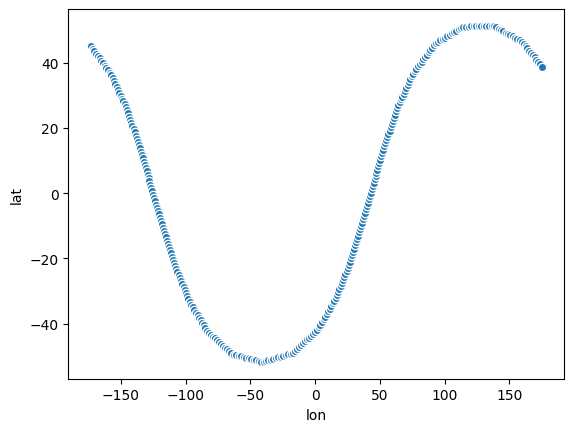

In [ ]:
interpolated_data.plot.scatter(x='lon', y='lat')

<Axes: xlabel='lon', ylabel='lat'>

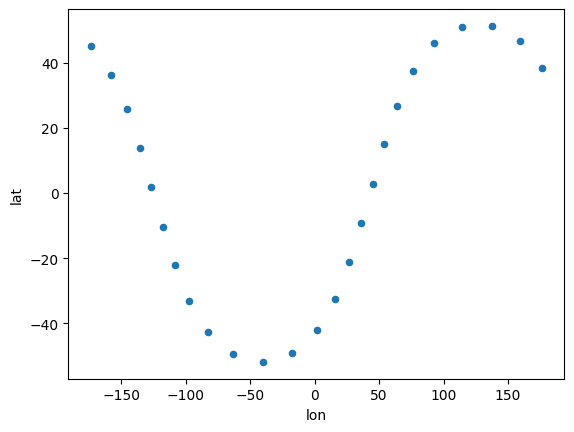

In [ ]:
df_orbit.plot.scatter(x='lon', y='lat')

In [ ]:
def count_orbit2(ds):
    count = 0
    temp_ds = ds['lon'].values
    print(len(temp_ds))
    for i in range(len(temp_ds)-1):
        print((temp_ds[i]), (temp_ds[i+1]))
        if (temp_ds[i] > 0) and (temp_ds[i+1] < 0):
            count += 1
            print(temp_ds[i], temp_ds[i+1])
    return count

In [ ]:
count_orbit2(interpolated_data)

288
-173.00161573795117 -171.6762682442134
-171.6762682442134 -170.3509207504756
-170.3509207504756 -169.0255732567378
-169.0255732567378 -167.70022576300002
-167.70022576300002 -166.37487826926224
-166.37487826926224 -165.04953077552446
-165.04953077552446 -163.72418328178665
-163.72418328178665 -162.39883578804887
-162.39883578804887 -161.0734882943111
-161.0734882943111 -159.7481408005733
-159.7481408005733 -158.4227933068355
-158.4227933068355 -157.17536098236712
-157.17536098236712 -156.16167416570696
-156.16167416570696 -155.1479873490468
-155.1479873490468 -154.13430053238662
-154.13430053238662 -153.12061371572645
-153.12061371572645 -152.10692689906625
-152.10692689906625 -151.09324008240608
-151.09324008240608 -150.07955326574591
-150.07955326574591 -149.06586644908575
-149.06586644908575 -148.05217963242558
-148.05217963242558 -147.03849281576538
-147.03849281576538 -146.0248059991052
-146.0248059991052 -145.0581409865447
-145.0581409865447 -144.23254138628303
-144.232541386

0

In [ ]:
df_orbit.head(1)

,lat,lon
t,,
2024-12-19 21:49:00,45.15369,-173.332953


In [ ]:
df_orbit.tail(1)

,lat,lon
t,,
2024-12-19 23:25:00,38.288824,176.169714
